# Portfolio Risk

In [1]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

import logging
from pathlib import Path

import numpy as np
import pandas as pd
from IPython.display import Image, display
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

logging.basicConfig(level=logging.CRITICAL)

from lightgbm.sklearn import LGBMRegressor
from skfin.backtesting import Backtester
from skfin.datasets_ import load_kf_returns
from skfin.estimators import MLPRegressor, MultiOutputRegressor, RidgeCV
from skfin.metrics import sharpe_ratio
from skfin.mv_estimators import MeanVariance
from skfin.plot import *
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

returns_data = load_kf_returns(cache_dir="data")
ret = returns_data["Monthly"]["Average_Value_Weighted_Returns"][:"1999"]

transform_X = lambda x: x.rolling(12).mean().fillna(0)
transform_y = lambda x: x.shift(-1)
features = transform_X(ret)
target = transform_y(ret)

A key ingredient of portfolio construction is the ability to predict portfolio risk (in particular, with a risk-model) to be able to properly size the positions. 

In this section, we discuss different ways to estimate risk. More precisely, for the empirical covariance matrix $V$, there might be transformation $\Phi: V \mapsto V_{\Phi}$ that improve the forward-looking estimates (and the portfolio construction). 

The risk-model is defined here as the covariance of returns $V$. To understand its impact on the backtest, it is important to remember that in the mean-variance optimisation, it is the inverse of the covariance matrix $V^{-1}$ that is used. 

Viewed from the point of view of a singular value decomposition, the smallest eigenvalues of $V$ are not only estimated with noise, but their impact is magnified in $V^{-1}$, leading to potentially significant noise in the estimate of positions. 

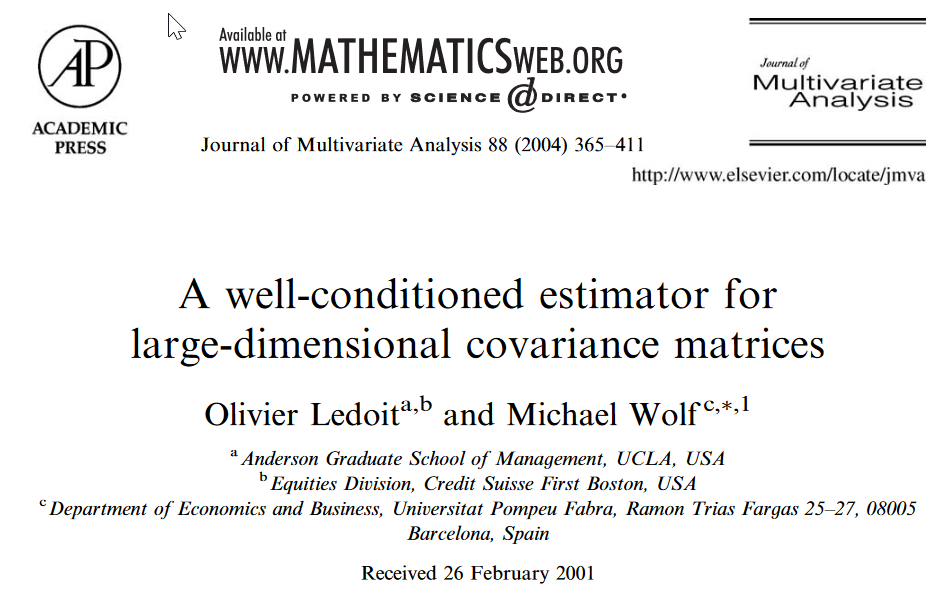

In [2]:
# hide
display(Image("images/ledoit_2004.png", width=600))

The insight of Ledoit and Wolf (2004) is to use a weighted average of two matrices to reduce estimation error

- the empirical covariance matrix $V$ is asymptotically an unbiased estimated – but with a slow convergence for small samples

- there are biased estimators but with a faster rate of convergence –- for instance the diagonal $Diag(V)$ of $V$ -- and on smaller samples, such biased estimators can be more efficient than the unbiased ones

- The covariance matrix used in the portfolio optimisation is 

$$V_{\omega} = \omega \times Diag(V) + (1-\omega) \times V.$$

How to determine $\omega$? Ledoit and Wolf (2004) minimize a norm that applies to matrices (Frobenius norm). In what follows, we test different shrinkage values. 

## Risk in the industry momentum backtest

In [3]:
from skfin.metrics import drawdown, sharpe_ratio

We first compute the Industry momentum benchmark. 

In [4]:
m = Backtester(MeanVariance()).compute_holdings(features, target).compute_pnl(ret)
h0, pnl0, estimators0 = m.h_, m.pnl_, m.estimators_

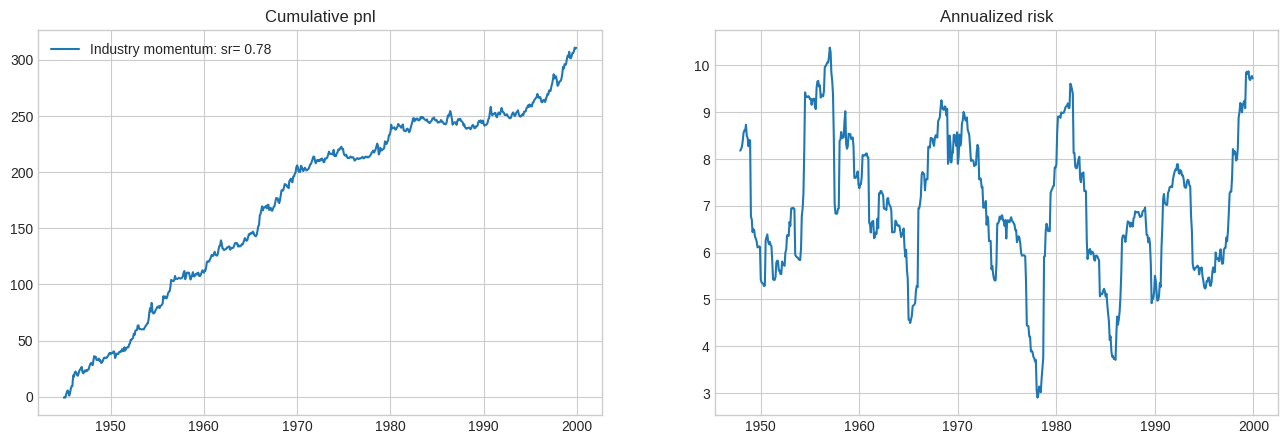

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
line(
    pnl0.rename("Industry momentum"),
    cumsum=True,
    loc="best",
    title="Cumulative pnl",
    ax=ax[0],
)
line(
    pnl0.rolling(36).std().mul(np.sqrt(12)),
    title="Annualized risk",
    legend=False,
    ax=ax[1],
)

The definition of a drawdown (in unit of annualized risk) is: 
    
$$ dd_t = \frac{\sum_{s=0}^{s=t} pnl_s - Max_{\tau}\left(\sum_{s=0}^{s=\tau} pnl_s \right)}{annualized\_factor \times \sqrt{Var[pnl_s|s \leq t]} }.$$

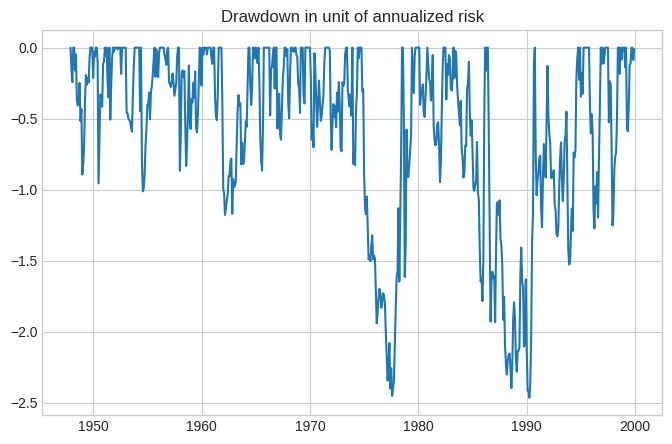

In [6]:
line(
    pnl0.pipe(drawdown),
    title="Drawdown in unit of annualized risk",
    legend=False,
    figsize=(8, 5),
)

The followning graph shows that on the period up to 2000, large absolute returns tend to be positive. It turns out that in the following period, the pnl of Momentum becomes left-skewed with large negative returns. For instance, February/March 2009 is a famous example of a Momentum drawdown. 

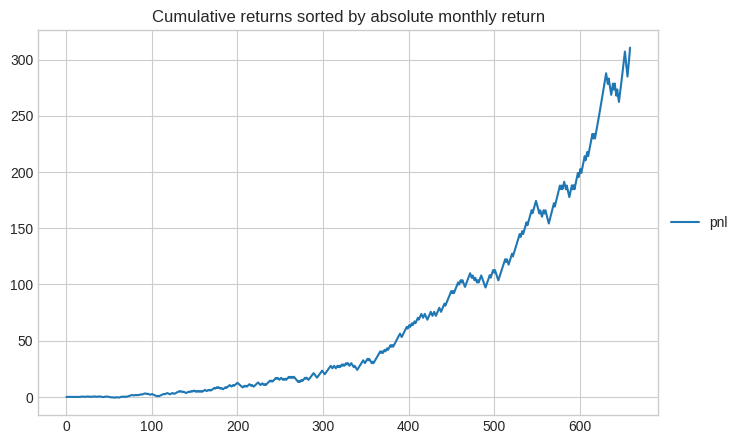

In [7]:
line(
    pnl0.rename("pnl")
    .to_frame()
    .assign(pnl_abs=lambda x: x.pnl.abs())
    .sort_values("pnl_abs")
    .reset_index(drop=True)["pnl"],
    cumsum=True,
    title="Cumulative returns sorted by absolute monthly return",
    legend_sharpe_ratio=False,
)

## Risk model estimation

In [8]:
from sklearn.covariance import LedoitWolf, ShrunkCovariance

The default value of the `shrinkage` parameter for `ShrunkCovariance` is 0.1. When `shrinkage=0`, there is no shrinkage and when `shrinkage=1`, all the off-diagonal terms are set to zero and the covariance matrix is diagonal.   

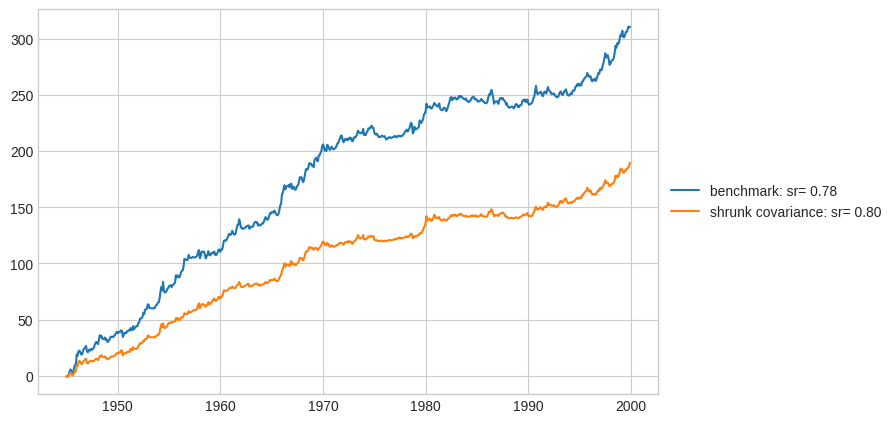

In [9]:
transform_V_ = lambda x: ShrunkCovariance(shrinkage=0.1).fit(x).covariance_
m = (
    Backtester(MeanVariance(transform_V=transform_V_))
    .compute_holdings(features, target)
    .compute_pnl(ret)
)
h, pnl, estimators = m.h_, m.pnl_, m.estimators_
line({"benchmark": pnl0, "shrunk covariance": pnl}, cumsum=True)

The estimation of risk with the shrunk covariance is much closer to the ex-ante risk (of 1). 

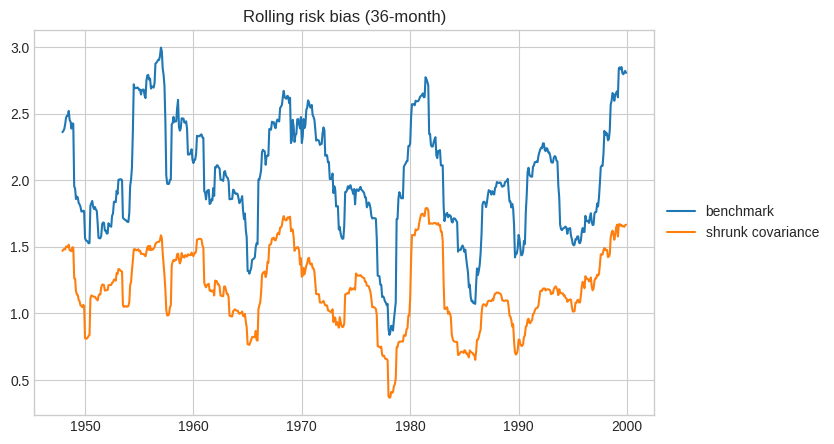

In [10]:
line(
    {"benchmark": pnl0.rolling(36).std(), "shrunk covariance": pnl.rolling(36).std()},
    title="Rolling risk bias (36-month)",
)

The ratio of the largest to the smallest eigenvalue is an order of magnitude smaller for the backtest with the shrunk covariance relative to the benchmark. 

In [11]:
for m in estimators0:
    break

In [12]:
s = np.linalg.svd(np.diag(np.diag(m.V_)), compute_uv=False)

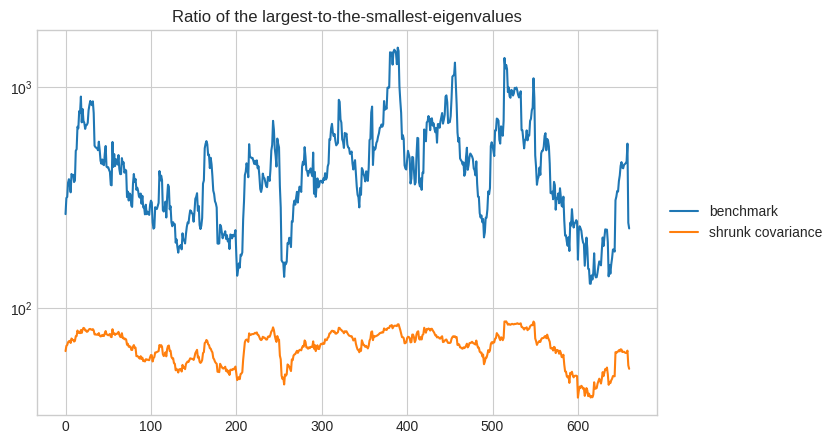

In [13]:
get_eigenvalues = lambda estimators: pd.DataFrame(
    [np.linalg.svd(m.V_, compute_uv=False) for m in estimators]
)

ratio_largest_smallest_eigenvalue = lambda x: x.pipe(
    lambda x: x.iloc[:, 0] / x.iloc[:, -1]
)

eigenvalues0 = get_eigenvalues(estimators0)
eigenvalues = get_eigenvalues(estimators)

line(
    {
        "benchmark": eigenvalues0.pipe(ratio_largest_smallest_eigenvalue),
        "shrunk covariance": eigenvalues.pipe(ratio_largest_smallest_eigenvalue),
    },
    yscale="log",
    title="Ratio of the largest-to-the-smallest-eigenvalues",
)

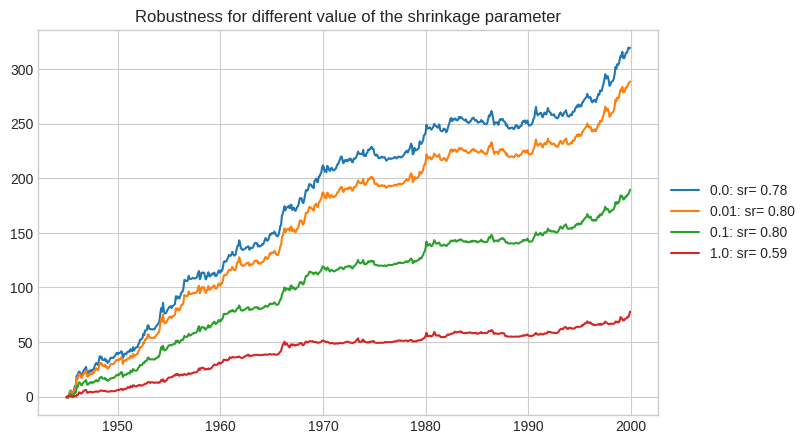

In [14]:
pnls = {}
for shrinkage in [0, 0.01, 0.1, 1]:
    transform_V_ = lambda x: ShrunkCovariance(shrinkage=shrinkage).fit(x).covariance_
    estimator = MeanVariance(transform_V=transform_V_)
    pnls[shrinkage] = Backtester(estimator).train(features, target, ret)
line(
    pnls, cumsum=True, title="Robustness for different value of the shrinkage parameter"
)

A related shrinkage is to use the `LedoitWolf` method to determine the shrinkage and it yield similar performance. 

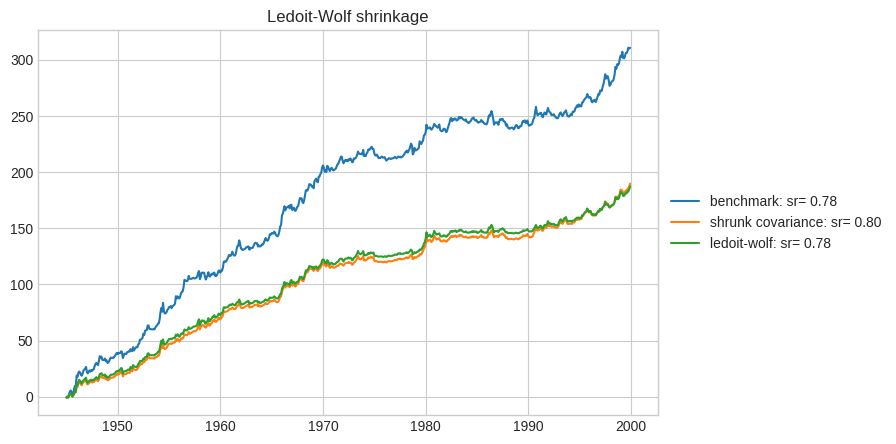

In [15]:
transform_V_ = lambda x: LedoitWolf().fit(x).covariance_
estimator = MeanVariance(transform_V=transform_V_)
pnl_ = Backtester(estimator).train(features, target, ret)
line(
    {"benchmark": pnl0, "shrunk covariance": pnl, "ledoit-wolf": pnl_},
    cumsum=True,
    title="Ledoit-Wolf shrinkage",
)

The key empirical point is that the sharpe ratio is maximized for a covariance that involves a small amount of shrinkage.